In [1]:
import osmnx as ox, networkx as nx, pandas as pd, geopandas as gpd, time, matplotlib.pyplot as plt, math, ast, re
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
import statsmodels.api as sm, numpy as np
from geopy.distance import great_circle
from shapely.geometry import Polygon
%matplotlib inline
ox.config(use_cache=True, log_file=True, log_console=True, log_filename='analyze_stats_every_us_urban_area',
          data_folder='G:/Geoff/osmnx/urbanized-areas-usa', cache_folder='G:/Geoff/osmnx/cache')

In [2]:
df = pd.read_csv('data/usa_stats.csv', encoding='utf-8')
len(df)

497

In [3]:
df['city'] = df['name'].map(lambda x: re.findall(r'^[a-z A-Z\s\.]*', x)[0])

In [4]:
df['streets_per_node_proportion'] = [ast.literal_eval(p) for p in df['streets_per_node_proportion']]

## Plot distribution of intersection types for 9 cities

In [5]:
names = ['Detroit', 'Lubbock', 'Chattanooga', 'Duluth', 'New Orleans', 'Phoenix',
         'Boston', 'Atlanta', 'Chicago']
stats_plot = df[df['city'].isin(names)]
stats_plot = stats_plot.sort_values('area', ascending=False)
stats_plot['city']

1          Atlanta
2          Chicago
4           Boston
8          Detroit
11         Phoenix
67     Chattanooga
80     New Orleans
188        Lubbock
256         Duluth
Name: city, dtype: object

In [6]:
proportion_streets_per_intersection = stats_plot['streets_per_node_proportion'].tolist()
names_full = stats_plot['name'].tolist()
names = [re.findall(r'^[a-zA-Z\s]*', name)[0] for name in names_full]

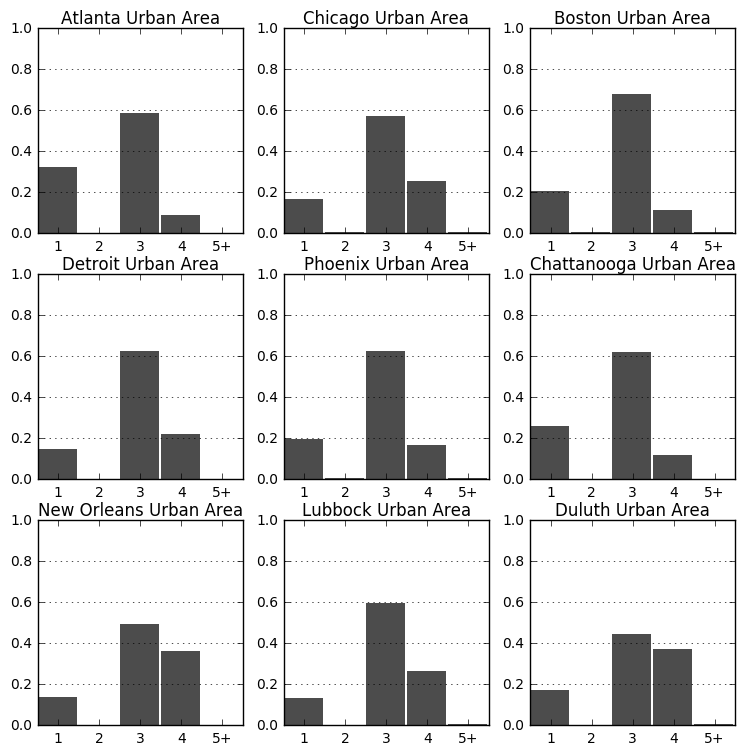

In [7]:
n = len(proportion_streets_per_intersection)
cols = 3
rows = int(n / cols)
max_value = 4
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (prop, name) in enumerate(zip(proportion_streets_per_intersection, names)):
    
    row = math.floor(i / cols)
    col = i % cols
    ax = axes[row][col]
    
    all_others = sum(list(prop.values())[max_value + 1:])
    prop = {key:value for key, value in prop.items() if key <= max_value}
    prop[max_value + 1] = all_others
    lefts = [x - 0.5 for x in prop.keys()]
    
    ax.bar(left=lefts, height=prop.values(), width=0.95, alpha=0.7,
           color='k', linewidth=0)
    ax.yaxis.grid(True)
    xticklabels = list(range(0, max_value + 1)) + ['{}+'.format(max_value + 1)]
    ax.set_xticklabels(xticklabels)
    
    ax.set_title('{} Urban Area'.format(name), fontsize=12, y=0.99)
    ax.set_xlim(0.5, max_value + 1.5)
    ax.set_ylim(0, 1)

In [8]:
# which cities have high proportion of cul-de-sacs
prop = df['streets_per_node_proportion'].tolist()
df.loc[pd.DataFrame(prop, index=df.index).sort_values(1, ascending=False).head(20).index]['name']

87     Aguadilla--Isabela--San Sebastián, PR Urbanize...
219                           Arecibo, PR Urbanized Area
191    San Germán--Cabo Rojo--Sabana Grande, PR Urban...
357      Florida--Imbéry--Barceloneta, PR Urbanized Area
335    Lexington Park--California--Chesapeake Ranch E...
17                           San Juan, PR Urbanized Area
226                        Marysville, WA Urbanized Area
313                          Mayagüez, PR Urbanized Area
343                        Juana Díaz, PR Urbanized Area
236                     Santa Clarita, CA Urbanized Area
143                         Bremerton, WA Urbanized Area
354                             Yauco, PR Urbanized Area
96                            Concord, CA Urbanized Area
398    Kailua (Honolulu County)--Kaneohe, HI Urbanize...
220             Mauldin--Simpsonville, SC Urbanized Area
297           Westminster--Eldersburg, MD Urbanized Area
1                             Atlanta, GA Urbanized Area
76                            H

In [9]:
df.sort_values(by='circuity_avg', ascending=True).head()

,area,area_km,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,circuity_avg,clustering_coefficient_avg,clustering_coefficient_weighted_avg,count_intersections,degree_centrality_avg,edge_density_km,...,self_loop_proportion,street_density_km,street_length_avg,street_length_total,street_segments_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportion,time,city
318,137141203,137.141203,3.186932,0.026364,1.023078,0.021581,0.001063,4248,0.001213,17053.044931,...,0.000420,9158.985735,168.781822,1.256074e+06,7442,3.118483,"{0: 0, 1: 605, 2: 1, 3: 2477, 4: 1756, 5: 12, ...","{0: 0.0, 1: 0.12466515557387184, 2: 0.00020605...",4.170194,Midland
292,152630919,152.630919,3.227746,0.027396,1.026085,0.029203,0.002627,4614,0.001184,17393.711201,...,0.001162,8954.618296,173.710170,1.366752e+06,7868,3.149335,"{0: 0, 1: 502, 2: 3, 3: 2846, 4: 1759, 5: 6}","{0: 0.0, 1: 0.09812353401094605, 2: 0.00058639...",4.127811,Odessa
188,249860381,249.860381,2.966299,0.026249,1.027834,0.024814,0.001050,8890,0.000533,17417.197884,...,0.001325,9782.132086,161.107854,2.444167e+06,15171,3.009767,"{0: 0, 1: 1349, 2: 12, 3: 6123, 4: 2705, 5: 45...","{0: 0.0, 1: 0.13175114757300518, 2: 0.00117198...",8.889033,Lubbock
228,210823472,210.823472,3.137191,0.029719,1.028116,0.024171,0.001234,7407,0.000701,17066.324284,...,0.001900,9268.919897,150.768141,1.954106e+06,12961,3.164280,"{0: 0, 1: 902, 2: 43, 3: 4177, 4: 3165, 5: 19,...","{0: 0.0, 1: 0.10855698640028884, 2: 0.00517511...",7.219486,Amarillo
283,160423274,160.423274,3.007582,0.135107,1.034139,0.037476,0.002489,2660,0.001665,11136.688427,...,0.002956,5717.765492,203.429288,9.172627e+05,4509,2.852353,"{0: 0, 1: 591, 2: 4, 3: 1958, 4: 691, 5: 6, 6: 1}","{0: 0.0, 1: 0.1817902183943402, 2: 0.001230390...",2.588383,Vineland


In [10]:
# filter df for outliers in some column
#col = 'node_count'
stats_plot = df#[df[col] < 100000]
print('Threw out {} greatest {} outliers'.format(len(df)-len(stats_plot), col))

Threw out 0 greatest 2 outliers


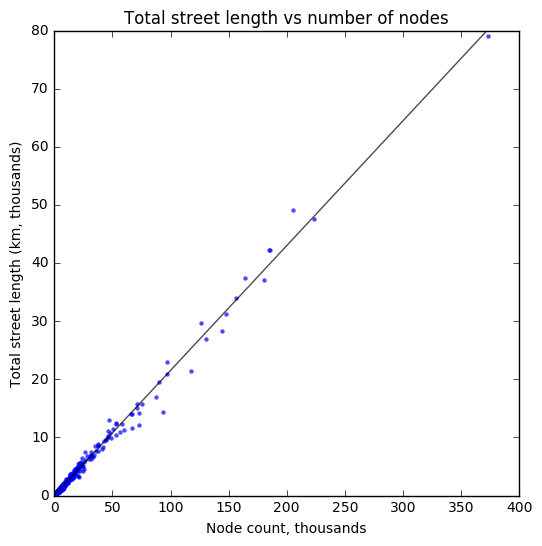

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
x = stats_plot['n'] / 1000
y = stats_plot['street_length_total'] / 1000 / 1000

xlim = [0, math.ceil(x.max()/100)*100] #round to nearest greater 100
ylim = [0, math.ceil(y.max()/20)*20] #round to nearest greater 20

# regress y on x
results = sm.OLS(y, sm.add_constant(x)).fit()

# calculate estimated y values for regression line
x_line = pd.Series(xlim)
y_est = x_line * results.params[1] + results.params[0]

# draw regression line and scatter plot the points
ax.plot(x_line, y_est, c='k', alpha=0.7, linewidth=1, zorder=1)
ax.scatter(x=x, y=y, c='b', linewidths=0, alpha=0.7, s=10)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
#ax.set_xlim((0,15000))
#ax.set_ylim((0,3000))

ax.set_title('Total street length vs number of nodes')
ax.set_xlabel('Node count, thousands')
ax.set_ylabel('Total street length (km, thousands)')

fig.savefig(filename='images/usa-ua-street-length-vs-nodes', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
print(results.rsquared)
results.params

0.992167923003


const    0.036710
n        0.214779
dtype: float64

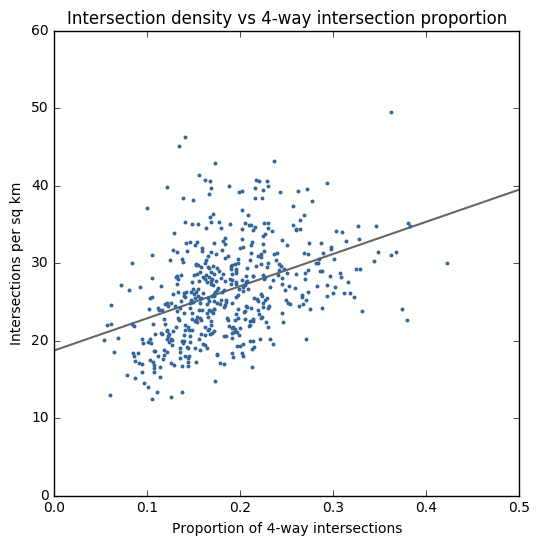

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
y = stats_plot['intersection_density_km']
x = stats_plot['int_4_streets_prop']

ylim = (0,60)
xlim = (0,0.5)

# regress y on x
results = sm.OLS(y, sm.add_constant(x)).fit()

# calculate estimated y values for regression line
x_line = pd.Series(xlim)
y_est = x_line * results.params[1] + results.params[0]

# draw regression line and scatter plot the points
ax.plot(x_line, y_est, c='k', alpha=0.6, linewidth=1.5, zorder=-1)
ax.scatter(x=x, y=y, c='#336699', linewidths=0, alpha=1, s=8)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('Intersection density vs 4-way intersection proportion')
ax.set_ylabel('Intersections per sq km')
ax.set_xlabel('Proportion of 4-way intersections')

fig.savefig(filename='images/usa-ua-circuity-vs-k4', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
print('r-squared:', results.rsquared)
results.params

r-squared: 0.172039190453


const                 18.719630
int_4_streets_prop    41.497091
dtype: float64

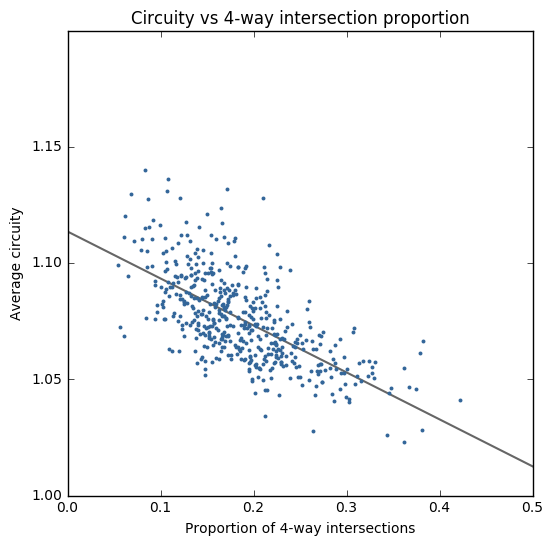

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
y = stats_plot['circuity_avg']
x = stats_plot['int_4_streets_prop']

ylim = (1,1.2)
xlim = (0,0.5)

# regress y on x
results = sm.OLS(y, sm.add_constant(x)).fit()

# calculate estimated y values for regression line
x_line = pd.Series(xlim)
y_est = x_line * results.params[1] + results.params[0]

# draw regression line and scatter plot the points
ax.plot(x_line, y_est, c='k', alpha=0.6, linewidth=1.5, zorder=-1)
ax.scatter(x=x, y=y, c='#336699', linewidths=0, alpha=1, s=8)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('Circuity vs 4-way intersection proportion')
ax.set_ylabel('Average circuity')
ax.set_xlabel('Proportion of 4-way intersections')

fig.savefig(filename='images/usa-ua-circuity-vs-k4', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
print('r-squared:', results.rsquared)
results.params

r-squared: 0.426644844251


const                 1.113551
int_4_streets_prop   -0.201993
dtype: float64

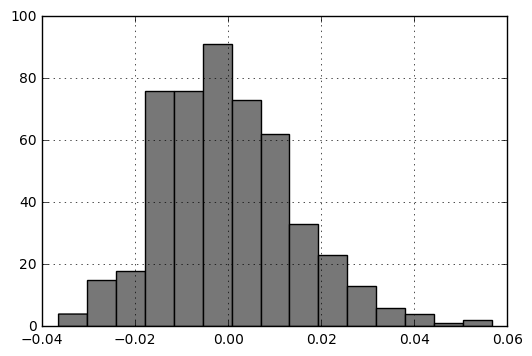

In [17]:
ax = results.resid.hist(bins=15, figsize=(6,4), fc='#777777', ec='k')

In [18]:
df.columns

Index(['area', 'area_km', 'avg_neighbor_degree_avg',
       'avg_weighted_neighbor_degree_avg', 'circuity_avg',
       'clustering_coefficient_avg', 'clustering_coefficient_weighted_avg',
       'count_intersections', 'degree_centrality_avg', 'edge_density_km',
       'edge_length_avg', 'edge_length_total', 'geoid', 'int_0_streets_count',
       'int_0_streets_prop', 'int_10_streets_count', 'int_10_streets_prop',
       'int_11_streets_count', 'int_11_streets_prop', 'int_1_streets_count',
       'int_1_streets_prop', 'int_2_streets_count', 'int_2_streets_prop',
       'int_3_streets_count', 'int_3_streets_prop', 'int_4_streets_count',
       'int_4_streets_prop', 'int_5_streets_count', 'int_5_streets_prop',
       'int_6_streets_count', 'int_6_streets_prop', 'int_7_streets_count',
       'int_7_streets_prop', 'int_8_streets_count', 'int_8_streets_prop',
       'int_9_streets_count', 'int_9_streets_prop', 'intersection_density_km',
       'k_avg', 'm', 'n', 'name', 'node_density_km', 'p

In [19]:
cols = ['area_km', 'avg_neighbor_degree_avg',
       'avg_weighted_neighbor_degree_avg', 'circuity_avg',
       'clustering_coefficient_avg', 'clustering_coefficient_weighted_avg',
       'count_intersections', 'degree_centrality_avg', 'edge_density_km',
       'edge_length_avg', 'edge_length_total', 'geoid',
       'int_1_streets_prop', 'int_3_streets_prop', 'int_4_streets_prop', 'intersection_density_km',
       'k_avg', 'm', 'n', 'name', 'node_density_km', 'pagerank_max',
       'pagerank_min',
       'self_loop_proportion', 'street_density_km', 'street_length_avg',
       'street_length_total', 'street_segments_count', 'streets_per_node_avg', 'city']
summary = df[cols]
summary = summary.describe().T.drop(['count', '25%', '75%'], axis=1).applymap(lambda x: round(x, 3))
summary.to_csv('data/summary.csv', encoding='utf-8')

In [20]:
cols = ['area_km',
       'circuity_avg',
       'clustering_coefficient_avg',
       'int_1_streets_prop', 'int_3_streets_prop', 'int_4_streets_prop', 'intersection_density_km',
       'street_density_km', 'street_length_avg',
       'streets_per_node_avg', 'city']
largest_metros = df[cols].head(30).applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

In [21]:
largest_metros.to_csv('data/largest_metros.csv', encoding='utf-8')

In [22]:
largest_metros.columns

Index(['area_km', 'circuity_avg', 'clustering_coefficient_avg',
       'int_1_streets_prop', 'int_3_streets_prop', 'int_4_streets_prop',
       'intersection_density_km', 'street_density_km', 'street_length_avg',
       'streets_per_node_avg', 'city'],
      dtype='object')

In [23]:
variable = 'street_length_avg'
largest_metros[['city', variable]].sort_values(by=variable, ascending=False)

,city,street_length_avg
19,Cleveland,197.58
18,Cincinnati,185.76
1,Atlanta,185.66
28,Nashville,181.10
20,Charlotte,170.13
12,Minneapolis,166.55
16,Pittsburgh,164.64
26,Orlando,163.34
2,Chicago,163.25
27,San Antonio,162.45


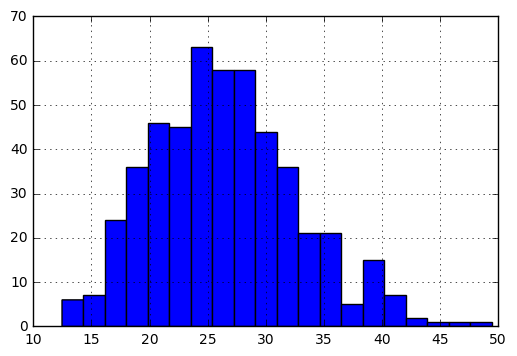

In [24]:
df['intersection_density_km'].hist(bins=20)

In [25]:
df.columns

Index(['area', 'area_km', 'avg_neighbor_degree_avg',
       'avg_weighted_neighbor_degree_avg', 'circuity_avg',
       'clustering_coefficient_avg', 'clustering_coefficient_weighted_avg',
       'count_intersections', 'degree_centrality_avg', 'edge_density_km',
       'edge_length_avg', 'edge_length_total', 'geoid', 'int_0_streets_count',
       'int_0_streets_prop', 'int_10_streets_count', 'int_10_streets_prop',
       'int_11_streets_count', 'int_11_streets_prop', 'int_1_streets_count',
       'int_1_streets_prop', 'int_2_streets_count', 'int_2_streets_prop',
       'int_3_streets_count', 'int_3_streets_prop', 'int_4_streets_count',
       'int_4_streets_prop', 'int_5_streets_count', 'int_5_streets_prop',
       'int_6_streets_count', 'int_6_streets_prop', 'int_7_streets_count',
       'int_7_streets_prop', 'int_8_streets_count', 'int_8_streets_prop',
       'int_9_streets_count', 'int_9_streets_prop', 'intersection_density_km',
       'k_avg', 'm', 'n', 'name', 'node_density_km', 'p

In [26]:
variable = 'intersection_density_km'
df[['name', variable]].sort_values(by=variable, ascending=False)

,name,intersection_density_km
80,"New Orleans, LA Urbanized Area",49.423366
137,"Indio--Cathedral City, CA Urbanized Area",46.274670
47,"Las Vegas--Henderson, NV Urbanized Area",45.038908
35,"San Francisco--Oakland, CA Urbanized Area",43.165991
70,"San Jose, CA Urbanized Area",42.948393
474,"Livermore, CA Urbanized Area",41.308848
485,"Manteca, CA Urbanized Area",40.740995
436,"Boulder, CO Urbanized Area",40.691612
25,"Denver--Aurora, CO Urbanized Area",40.597645
102,"Colorado Springs, CO Urbanized Area",40.562174


## Map the urbanized areas by attribute

In [27]:
gdf = gpd.read_file('input_data/tl_2016_us_uac10')
df['geoid'] = df['geoid'].astype(str)
data = pd.merge(left=gdf, right=df, left_on='GEOID10', right_on='geoid')
data.to_file('data/urbanized_areas_stats')

In [28]:
variable = 'intersection_density_km'
data = data[['geometry', 'city', variable]].sort_values(by=variable)
color_list = [cm.get_cmap('plasma')(x) for x in np.linspace(0, 1, len(data))]

In [29]:
# project to ESRI's North America Lambert Conformal Conic 
#data = data.to_crs({'init': 'ESRI:102008'})

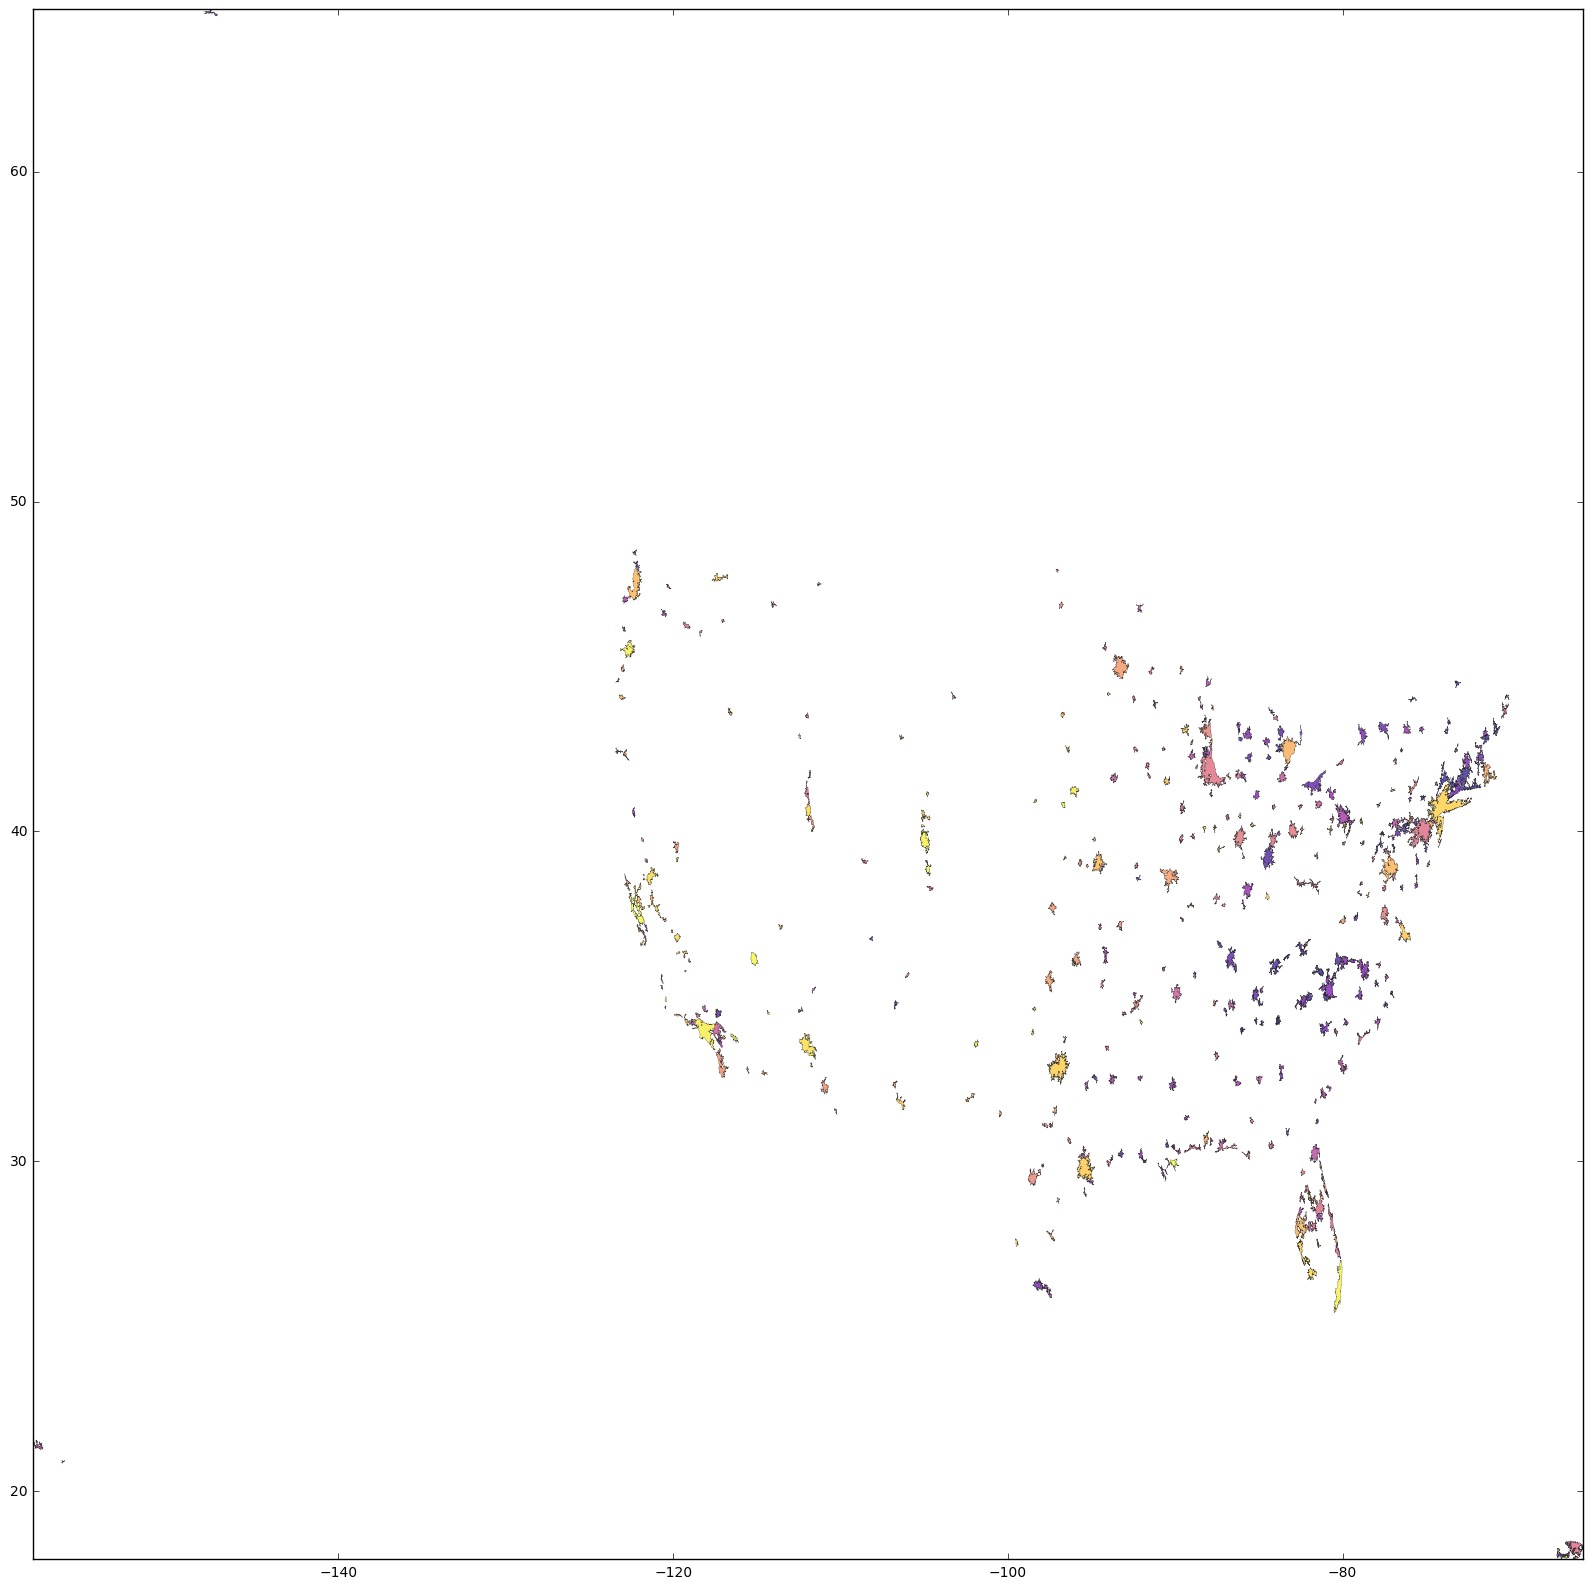

In [30]:
fig, ax = plt.subplots(figsize=(20,20))

# extract each polygon as a descartes patch, and add to a matplotlib patch collection...
patches = []
fc = []
for geometry, color in zip(data['geometry'], color_list):
    if isinstance(geometry, Polygon):
        patches.append(PolygonPatch(geometry))
        fc.append(color)
    elif isinstance(geometry, MultiPolygon):
        for subpolygon in geometry: #if geometry is multipolygon, go through each constituent subpolygon
            patches.append(PolygonPatch(subpolygon))
            fc.append(color)
pc = PatchCollection(patches, facecolor=fc, linewidth=0.2, alpha=0.7)
ax.add_collection(pc)

# set the figure bounds to the polygons' bounds
left, bottom, right, top = data.total_bounds
ax.set_xlim((left,right))
ax.set_ylim((bottom,top))
#ax.axis('off')
plt.show()